This is the second version of the project. It was made to explore alternative methods that we could not use in the other file. Both of the python files are our submission

In [ ]:
import pandas as pd
import zipfile
import os

# Path to the ZIP file and the CSV file within it
zip_file_path = '/content/dataset.zip'
csv_file_name = 'scores.csv'  # Assuming the CSV is named 'scores.csv'

# Unzip the dataset
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    # Extract all the contents into the directory '/content'
    zip_ref.extractall('/content')  # Corrected this line

# Define the full path to the CSV file
# Assuming the CSV file is in the root of the zip and not inside a nested directory
csv_file_path = os.path.join('/content', csv_file_name)

# Read the CSV file into a DataFrame
scores_df = pd.read_csv(csv_file_path)

# Display the first few rows of the DataFrame
print(scores_df.head())

   Unnamed: 0                                  code  grade
0           0  6a2003ad-a05a-41c9-9d48-e98491a90499   90.0
1           1  04f91058-d0f8-4324-83b2-19c671f433dc   97.0
2           2  81fdeb2a-e7e5-4a05-8058-d31ea579b0d9   94.0
3           3  6a903495-c5be-4263-b4dd-75e2bbc30434   97.0
4           4  6d5742c1-77c4-429c-8f6e-ef1262ca5557   93.0


In [ ]:
import os
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import re
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from tqdm import tqdm
from glob import glob
import scipy.sparse

# Set the path to your HTML and CSV files
data_path = "/content/dataset/*.html"
scores_csv_path = "/content/scores.csv"

# Extract text data from HTML files
code2convos = {}
for path in tqdm(sorted(glob(data_path))):
    file_code = os.path.basename(path).split(".")[0]
    with open(path, "r", encoding="latin1") as fh:
        html_page = fh.read()
        soup = BeautifulSoup(html_page, "html.parser")
        conversations = soup.find_all("div", attrs={"data-testid": re.compile(r"conversation-turn-[0-9]+")})
        convo_texts = []
        for convo in conversations:
            convo_parts = convo.find_all("div", attrs={"data-message-author-role": re.compile(r"(user|assistant)")})
            for part in convo_parts:
                role = part.get("data-message-author-role")
                text = part.get_text(strip=True)
                convo_texts.append((role, text))
        code2convos[file_code] = convo_texts

# Convert the structured dictionary to a pandas DataFrame
convos_df = pd.DataFrame([(code, " ".join(text for _, text in convos)) for code, convos in code2convos.items()],
                         columns=['ID', 'Text'])

# Load and combine with scores
scores_df = pd.read_csv(scores_csv_path)
scores_df.rename(columns={'code': 'ID'}, inplace=True)  # Rename 'code' to 'ID'
merged_df = pd.merge(convos_df, scores_df, on='ID')

# Assuming the 'grade' column is the one we want to predict
X = merged_df.drop(['ID', 'grade'], axis=1)
y = merged_df['grade']

# Feature extraction from text using TF-IDF
tfidf_vectorizer = TfidfVectorizer()
X_tfidf = tfidf_vectorizer.fit_transform(X['Text'])

# Assuming that the rest of your columns are numeric and you want to include them as features:
# For this example, let's just use the TF-IDF features
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

# Initialize the StandardScaler with with_mean=False to accommodate sparse matrices
scaler = StandardScaler(with_mean=False)
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Now your data is ready for modeling


100%|██████████| 127/127 [00:21<00:00,  5.81it/s]


In [ ]:
# Ensure you have the transformers library installed
!pip install transformers

In [ ]:
######## BERT Model BUT HIGHLY COMPUTATIONALLY EXPENSIVE AND TIME TAKING #########################
import os
import re
import json
import nbformat
from bs4 import BeautifulSoup
from glob import glob
from transformers import BertTokenizer, BertModel
import torch
from scipy.spatial.distance import cosine
import numpy as np

# Step 1: Extract text from HTML files
html_files_path = '/content/dataset/*.html'
extracted_prompts = []

for html_file in tqdm(glob(html_files_path)):
    with open(html_file, 'r', encoding='utf-8') as file:
        soup = BeautifulSoup(file, 'html.parser')
        texts = [p.get_text(strip=True) for p in soup.find_all('p')]
        extracted_prompts.extend(texts)

# Step 2: Extract homework questions from .ipynb file
notebook_path = '/content/Assignment.ipynb'
extracted_homework_questions = []

with open(notebook_path, 'r', encoding='utf-8') as f:
    notebook = nbformat.read(f, as_version=4)

for cell in notebook['cells']:
    if cell['cell_type'] == 'markdown':
        if cell['source'].startswith('Question'):
            extracted_homework_questions.append(cell['source'])

# Function to encode text using BERT
def encode_text(text, tokenizer, model):
    inputs = tokenizer(text, padding=True, truncation=True, max_length=512, return_tensors="pt")
    outputs = model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).squeeze().detach().cpu().numpy()

# Load pre-trained BERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

# If you're running this in a local setup and not in a hosted environment with a GPU,
# you should add the following line to tell PyTorch to use the CPU.
model = model.to('cpu')

# Step 3: Encode prompts and homework questions with BERT
prompts_embeddings = np.array([encode_text(prompt, tokenizer, model) for prompt in extracted_prompts])
questions_embeddings = np.array([encode_text(question, tokenizer, model) for question in extracted_homework_questions])

# Step 4: Calculate cosine similarity between prompts and homework questions
similarity_matrix = np.array([[1 - cosine(p, q) for q in questions_embeddings] for p in prompts_embeddings])

# Step 5: Find the best matching homework question for each prompt
for i, prompt in enumerate(extracted_prompts):
    best_match_idx = np.argmax(similarity_matrix[i])
    print(f"Prompt: {prompt}")
    print(f"Best matching homework question: {extracted_homework_questions[best_match_idx]}")
    print(f"Similarity score: {similarity_matrix[i][best_match_idx]}")
    print("\n")


100%|██████████| 127/127 [00:27<00:00,  4.61it/s]
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

KeyboardInterrupt: 

In [ ]:
# Install the sentence-transformers library
!pip install -U sentence-transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 2.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 12.6 MB/s eta 0:00:00
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125923 sha256=a83cdd9433514407738a6ec0d4322c3e5d636d6d012d1d5064bec113f65a65f7
  Stored in directory: /root/.cache/pip/wheels/62/f2/10/1e606fd5f02395388f74e7462910fe851042f97238cbbd902f
Successfully built sentence-transformers


In [ ]:

import os
import nbformat
from bs4 import BeautifulSoup
from glob import glob
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
from tqdm.auto import tqdm

# Load a pre-trained Sentence Transformer model
model = SentenceTransformer('all-MiniLM-L6-v2')

# Function to encode texts to get sentence embeddings with batching
def encode_texts(texts, model, batch_size=32):
    embeddings = []
    for start_index in tqdm(range(0, len(texts), batch_size), desc="Encoding"):
        texts_batch = texts[start_index:start_index+batch_size]
        embeddings_batch = model.encode(texts_batch, convert_to_numpy=True, show_progress_bar=False)
        embeddings.append(embeddings_batch)
    return np.vstack(embeddings)

# Function to read the .ipynb file and extract the questions
# def extract_questions_from_notebook(notebook_path):
#     with open(notebook_path, 'r', encoding='utf-8') as f:
#         notebook = nbformat.read(f, as_version=4)
#     extracted_questions = []
#     for cell in notebook['cells']:
#         if cell['cell_type'] == 'markdown':
#             cell_text = cell['source']
#             for line in cell_text.splitlines():
#                 if line.startswith(('* ', '- ')):  # Check for bullet points
#                     extracted_questions.append(line.strip('* ').strip('- ').strip())
#     return extracted_questions

def extract_questions_from_notebook(notebook_path):
    with open(notebook_path, 'r', encoding='utf-8') as f:
        notebook = nbformat.read(f, as_version=4)
    extracted_questions = []
    for cell in notebook['cells']:
        if cell['cell_type'] == 'markdown':
            cell_text = cell['source']
            # Add the whole cell text as one question, removing any leading/trailing whitespace
            extracted_questions.append(cell_text.strip())
    return extracted_questions

# Extract text from HTML files
html_files_path = '/content/dataset/*.html'
extracted_prompts = []
for html_file in tqdm(glob(html_files_path), desc='Extracting prompts'):
    with open(html_file, 'r', encoding='utf-8') as file:
        soup = BeautifulSoup(file, 'html.parser')
        texts = [p.get_text(strip=True) for p in soup.find_all('p')]
        extracted_prompts.extend(texts)

# Extract homework questions from .ipynb file
notebook_path = '/content/Assignment.ipynb'
extracted_homework_questions = extract_questions_from_notebook(notebook_path)

# Encode the prompts and homework questions
prompts_embeddings = encode_texts(extracted_prompts, model)
questions_embeddings = encode_texts(extracted_homework_questions, model)

# Calculate cosine similarity between prompts and homework questions
similarity_matrix = cosine_similarity(prompts_embeddings, questions_embeddings)

# Find the best matching homework question for each prompt
for i, prompt_embedding in enumerate(prompts_embeddings):
    best_match_idx = np.argmax(similarity_matrix[i])
    print(f"Prompt: {extracted_prompts[i]}")
    print(f"Best matching homework question: {extracted_homework_questions[best_match_idx]}")
    print(f"Similarity score: {similarity_matrix[i][best_match_idx]}")
    print("\n")


Extracting prompts:   0%|          | 0/127 [00:00<?, ?it/s]

Encoding:   0%|          | 0/474 [00:00<?, ?it/s]

Encoding:   0%|          | 0/1 [00:00<?, ?it/s]

Streaming output truncated to the last 5000 lines.


Prompt: You can use this function to compute entropy for any class distribution dictionary by passing the class distribution as an argument to thecalculate_entropyfunction.
Best matching homework question: Find the information gain on the first split with **Entropy** according to the formula from the lecture notes (given below)
Similarity score: 0.4423319697380066


Prompt: Sure, to calculate the entropy for a given set of class distributions and information gain using the formula you've mentioned, you can create a function as follows:
Best matching homework question: Find the information gain on the first split with **Entropy** according to the formula from the lecture notes (given below)
Similarity score: 0.5906276702880859


Prompt: This code defines two functions:calculate_entropyto compute entropy for a given class distribution dictionary andcalculate_information_gainto calculate information gain using entropy based on a parent 

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Streaming output truncated to the last 5000 lines.
Best matching homework question: Report the classification accuracy. (2 pts)
Similarity score: 0.3286074995994568


Prompt: If you are working with a binary classification problem and still getting a 3x3 confusion matrix, you may want to inspect the unique values in your target variable and prediction to identify any unexpected class labels. You can use the following code to check the unique values:
Best matching homework question: Plot & investigate the confusion matrix. Fill the following blanks. (8 pts)
Similarity score: 0.4272891581058502


Prompt: Ensure that you have a binary classification problem and that the unique values match your expectations. If there are three unique values, it indicates that the model or data may be treating the problem as a multiclass classification task.
Best matching homework question: Report the classification accuracy. (2 pts)
Similarity score: 0.40470361709594727


Prompt: If you want to convert yo

.gitattributes:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

data_config.json:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

train_script.py:   0%|          | 0.00/13.2k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

Extracting prompts:   0%|          | 0/127 [00:00<?, ?it/s]

Encoding:   0%|          | 0/474 [00:00<?, ?it/s]

Encoding:   0%|          | 0/1 [00:00<?, ?it/s]

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)




Best matching homework question: ## 3) Understanding the dataset & Preprocessing (15 pts)

Understanding the Dataset: (5 pts)


> - Find the shape of the dataset (number of samples & number of attributes). (Hint: You can use the **shape** function)

> - Display variable names (both dependent and independent).


> - Display the summary of the dataset. (Hint: You can use the **info** function)


> - Display the first 5 rows from training dataset. (Hint: You can use the **head** function)




Preprocessing: (10 pts)


> - Check if there are any missing values in the dataset. If there are, you can either drop these values or fill it with most common values in corresponding rows. **Be careful that you have enough data for training the  model.**


> - Encode categorical labels with the mappings given in the cell below. (Hint: You can use **map** function)
Similarity score: 0.3499215841293335


Prompt: Displaying variable names (dependent and independent):
Best matching homework question: ##
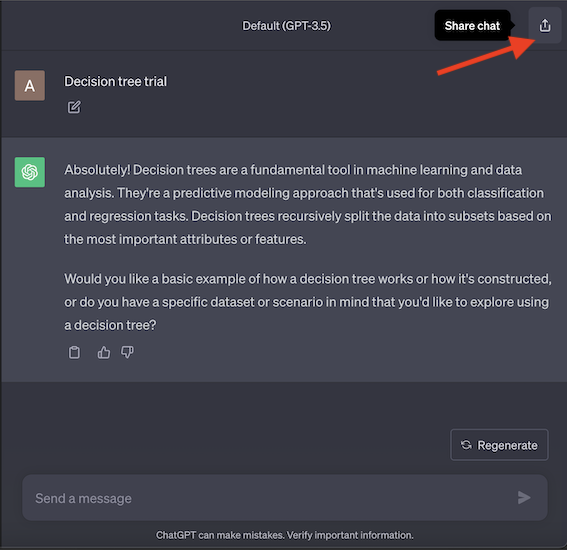
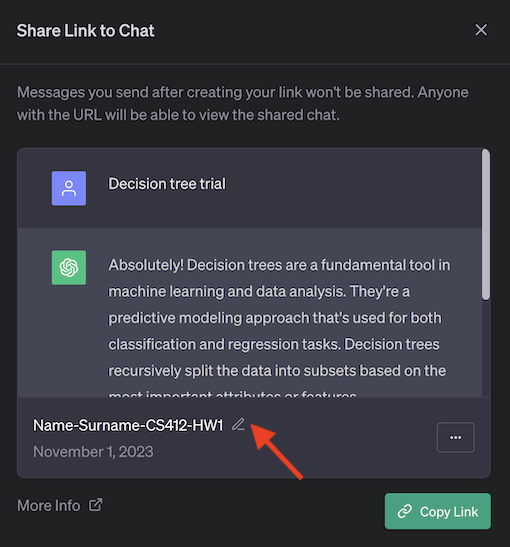
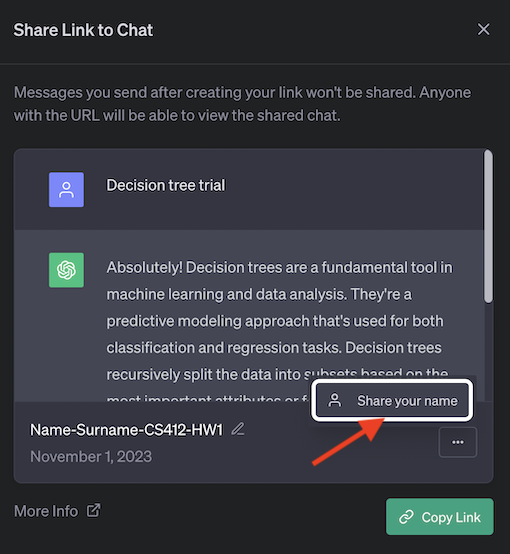
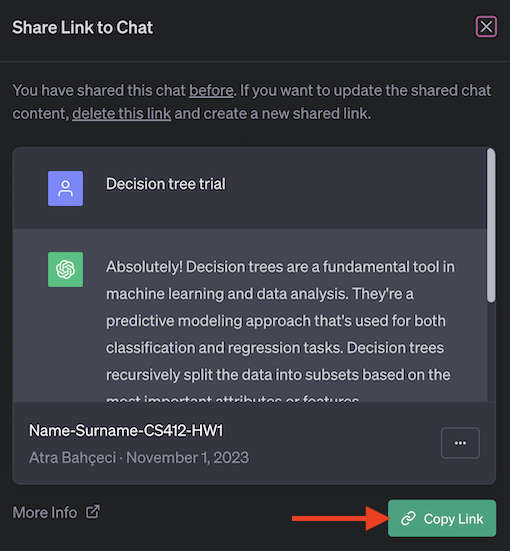
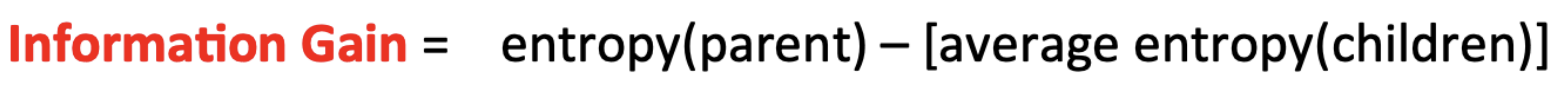
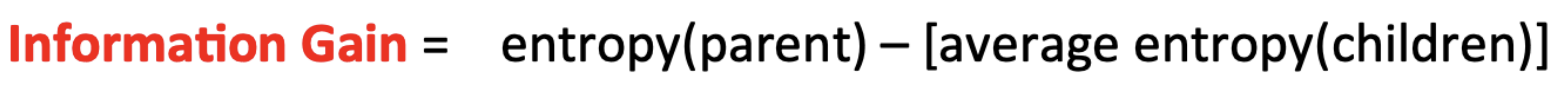
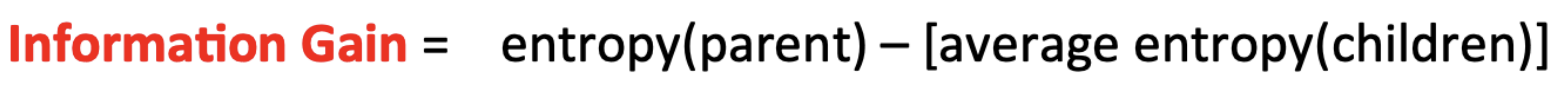
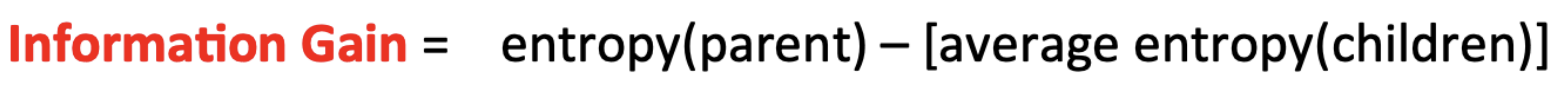
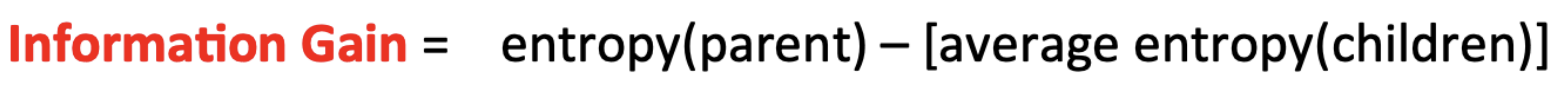
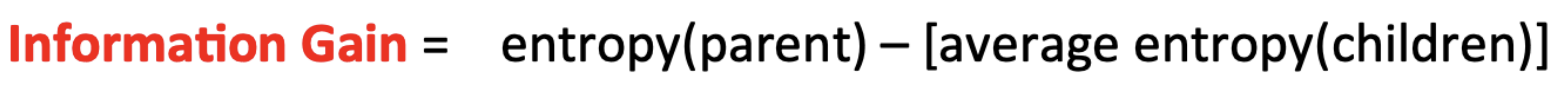
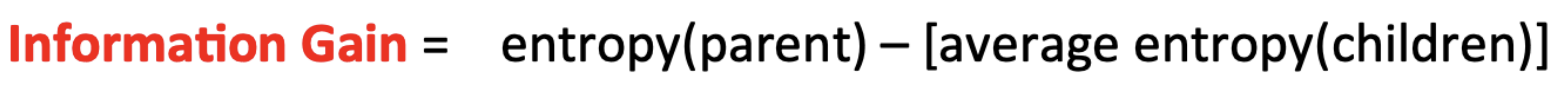
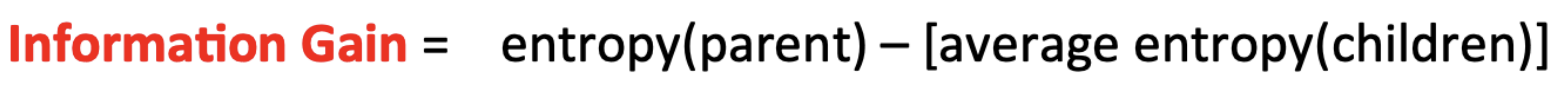
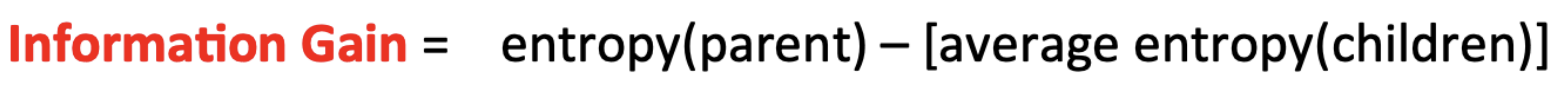
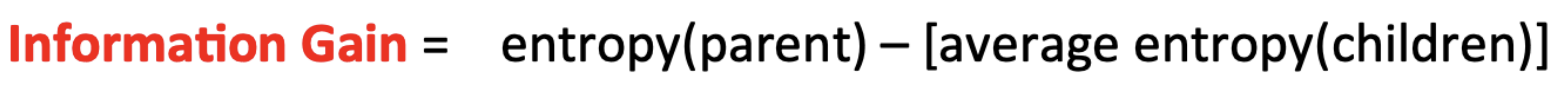

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [ ]:
###### Similar to the above method but less computationally expensive

import os
import nbformat
from bs4 import BeautifulSoup
from glob import glob
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
from tqdm.auto import tqdm

# Load a pre-trained Sentence Transformer model
model = SentenceTransformer('all-MiniLM-L6-v2')

# Function to encode texts to get sentence embeddings with batching
def encode_texts(texts, model, batch_size=32):
    embeddings = []
    for start_index in tqdm(range(0, len(texts), batch_size), desc="Encoding"):
        texts_batch = texts[start_index:start_index+batch_size]
        embeddings_batch = model.encode(texts_batch, convert_to_numpy=True, show_progress_bar=False)
        embeddings.append(embeddings_batch)
    return np.vstack(embeddings)

# Function to read the .ipynb file and extract the questions
# def extract_questions_from_notebook(notebook_path):
#     with open(notebook_path, 'r', encoding='utf-8') as f:
#         notebook = nbformat.read(f, as_version=4)
#     extracted_questions = []
#     for cell in notebook['cells']:
#         if cell['cell_type'] == 'markdown':
#             cell_text = cell['source']
#             for line in cell_text.splitlines():
#                 if line.startswith(('* ', '- ')):  # Check for bullet points
#                     extracted_questions.append(line.strip('* ').strip('- ').strip())
#     return extracted_questions

def extract_questions_from_notebook(notebook_path):
    with open(notebook_path, 'r', encoding='utf-8') as f:
        notebook = nbformat.read(f, as_version=4)
    extracted_questions = []
    for cell in notebook['cells']:
        if cell['cell_type'] == 'markdown':
            cell_text = cell['source']
            # Add the whole cell text as one question, removing any leading/trailing whitespace
            extracted_questions.append(cell_text.strip())
    return extracted_questions

# Extract text from HTML files
html_files_path = '/content/dataset/*.html'
extracted_prompts = []
for html_file in tqdm(glob(html_files_path), desc='Extracting prompts'):
    with open(html_file, 'r', encoding='utf-8') as file:
        soup = BeautifulSoup(file, 'html.parser')
        texts = [p.get_text(strip=True) for p in soup.find_all('p')]
        extracted_prompts.extend(texts)

# Extract homework questions from .ipynb file
notebook_path = '/content/Assignment.ipynb'
extracted_homework_questions = extract_questions_from_notebook(notebook_path)

# Encode the prompts and homework questions
prompts_embeddings = encode_texts(extracted_prompts, model)
questions_embeddings = encode_texts(extracted_homework_questions, model)

# Calculate cosine similarity between prompts and homework questions
similarity_matrix = cosine_similarity(prompts_embeddings, questions_embeddings)

# Find the best matching homework question for each prompt
for i, prompt_embedding in enumerate(prompts_embeddings):
    best_match_idx = np.argmax(similarity_matrix[i])
    print(f"Prompt: {extracted_prompts[i]}")
    print(f"Best matching homework question: {extracted_homework_questions[best_match_idx]}")
    print(f"Similarity score: {similarity_matrix[i][best_match_idx]}")
    print("\n")


(3430, 11)
Index(['species', 'island', 'bill_length_mm', 'bill_depth_mm',
       'flipper_length_mm', 'body_mass_g', 'sex', 'diet', 'life_stage',
       'health_metrics', 'year'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3430 entries, 0 to 3429
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   species            3182 non-null   object 
 1   island             3388 non-null   object 
 2   bill_length_mm     3240 non-null   float64
 3   bill_depth_mm      3167 non-null   float64
 4   flipper_length_mm  3219 non-null   float64
 5   body_mass_g        3200 non-null   float64
 6   sex                3179 non-null   object 
 7   diet               3163 non-null   object 
 8   life_stage         3361 non-null   object 
 9   health_metrics     3430 non-null   object 
 10  year               3387 non-null   float64
dtypes: float64(5), object(6)
memory usage: 294.9+ KB
None
  specie

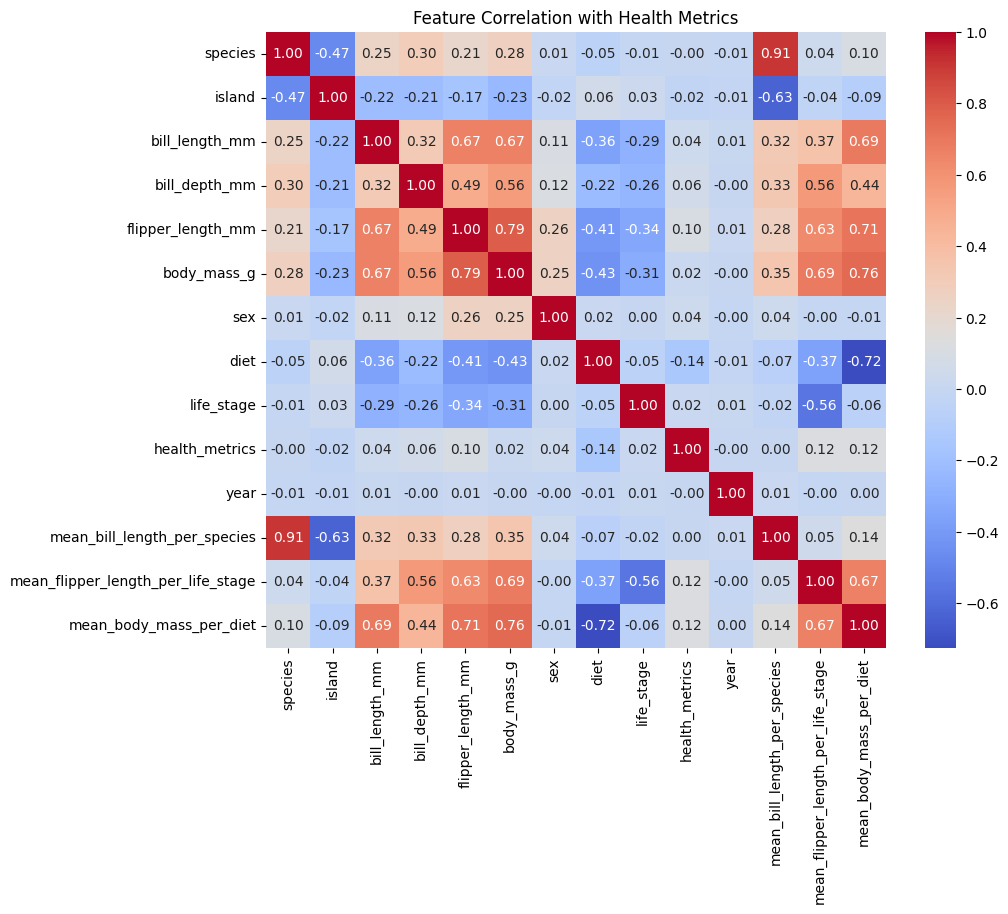

Strong predictors: ['diet', 'mean_flipper_length_per_life_stage', 'mean_body_mass_per_diet']


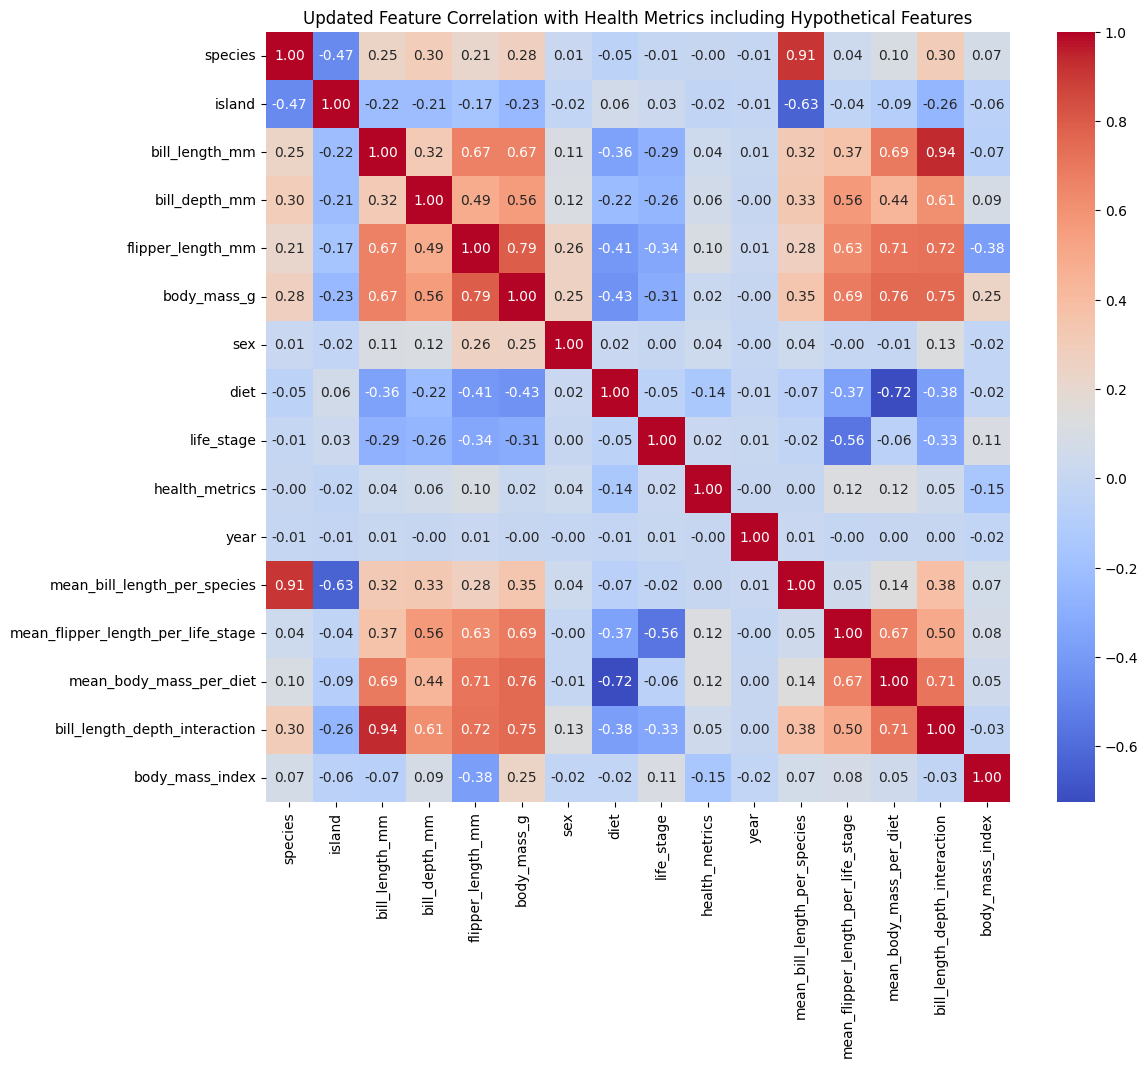

Updated strong predictors including hypothetical features: ['diet', 'mean_flipper_length_per_life_stage', 'mean_body_mass_per_diet', 'body_mass_index']


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load your dataset
df = pd.read_csv('/content/cs412_hw1_dataset.csv')

# Initial Data Exploration
print(df.shape)
print(df.columns)
print(df.info())
print(df.head())

# Check for Missing Values
print(df.isnull().sum())

# Feature Engineering
# Calculate mean measurements for species and life stages
df['mean_bill_length_per_species'] = df.groupby('species')['bill_length_mm'].transform('mean')
df['mean_flipper_length_per_life_stage'] = df.groupby('life_stage')['flipper_length_mm'].transform('mean')
df['mean_body_mass_per_diet'] = df.groupby('diet')['body_mass_g'].transform('mean')

# Encode Categorical Labels
categorical_columns = ['species', 'island', 'sex', 'diet', 'life_stage', 'health_metrics']
for col in categorical_columns:
    df[col] = df[col].astype('category').cat.codes

# Calculate Correlations
correlation_matrix = df.corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Feature Correlation with Health Metrics')
plt.show()

# Feature Selection
correlation_threshold = 0.1
target = 'health_metrics'
strong_predictors = [feature for feature in df.columns if feature != target and abs(correlation_matrix[feature][target]) > correlation_threshold]
print("Strong predictors:", strong_predictors)

# Propose Hypothetical Driver Features
df['bill_length_depth_interaction'] = df['bill_length_mm'] * df['bill_depth_mm']
df['body_mass_index'] = df['body_mass_g'] / (df['flipper_length_mm'] ** 2)

# Update the correlation matrix
correlation_matrix = df.corr()

# Update the heatmap including hypothetical features
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Updated Feature Correlation with Health Metrics including Hypothetical Features')
plt.show()

# Update strong predictors list
strong_predictors += [feature for feature in ['bill_length_depth_interaction', 'body_mass_index'] if abs(correlation_matrix[feature][target]) > correlation_threshold]
print("Updated strong predictors including hypothetical features:", strong_predictors)


In [ ]:
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV

# Load the data
df = pd.read_csv('/content/cs412_hw1_dataset.csv')

# Separate target variable and features
y = df['health_metrics']
X = df.drop(columns='health_metrics')

# Identify numeric and categorical columns
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(exclude=['int64', 'float64']).columns

# Create a ColumnTransformer with imputers for numeric and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', SimpleImputer(strategy='mean'), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# Create the preprocessing and modeling pipeline
pipeline = make_pipeline(
    preprocessor,
    DecisionTreeClassifier(random_state=42)
)

# Define the hyperparameters and their values for GridSearchCV
param_grid = {
    'decisiontreeclassifier__max_depth': [None, 2, 4, 6, 8],
    'decisiontreeclassifier__min_samples_split': [2, 5, 10]
}

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Set up GridSearchCV with the pipeline
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy')

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Print the best hyperparameters from GridSearchCV
print("Best hyperparameters:", grid_search.best_params_)



Best hyperparameters: {'decisiontreeclassifier__max_depth': None, 'decisiontreeclassifier__min_samples_split': 10}


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, PolynomialFeatures
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Load the data
df = pd.read_csv('/content/cs412_hw1_dataset.csv')

# Separate features and target
X = df.drop('health_metrics', axis=1)
y = df['health_metrics']

# Define numeric and categorical columns
numeric_columns = X.select_dtypes(include=['int64', 'float64']).columns
categorical_columns = X.select_dtypes(include=['object', 'category']).columns

# Create transformers for numeric and categorical data
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('poly', PolynomialFeatures(degree=2, include_bias=False))
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder())
])

# Combine transformers into a preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_columns),
        ('cat', categorical_transformer, categorical_columns)
    ])

# Create a pipeline with preprocessing and a classifier
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier())
])

# Define hyperparameters to tune
param_grid = {
    'classifier__max_depth': [None, 10, 20, 30],
    'classifier__min_samples_split': [2, 5, 10]
}

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Perform grid search
grid_search = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1, verbose=1, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Print the best hyperparameters
print("Best hyperparameters:", grid_search.best_params_)



Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best hyperparameters: {'classifier__max_depth': 20, 'classifier__min_samples_split': 10}


Classification accuracy: 0.81


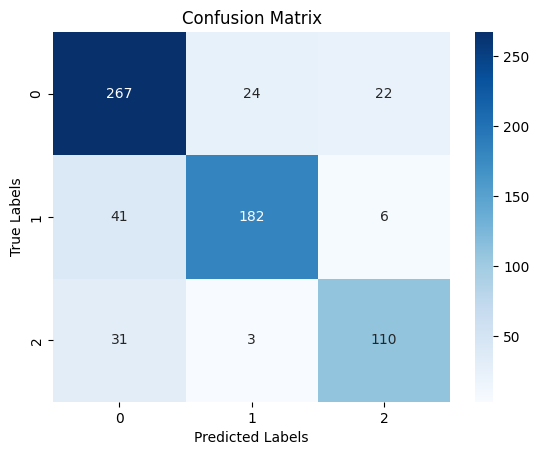

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming df is your dataframe

# Replace 'Adelie' with the actual column names of your categorical features
categorical_features = ['species', 'island', 'sex', 'diet', 'life_stage']

# Initialize LabelEncoder
le = LabelEncoder()

# Apply LabelEncoder to each categorical column
for col in categorical_features:
    df[col] = le.fit_transform(df[col])

# Initialize a SimpleImputer to fill missing values
imputer = SimpleImputer(strategy='mean')

# Apply SimpleImputer to numeric columns only
numeric_columns = df.select_dtypes(include=['int64', 'float64']).columns
df[numeric_columns] = imputer.fit_transform(df[numeric_columns])

# Now split your data into features and target, then into training and testing sets
# Assuming 'target_column' is the name of your target column
X = df.drop('health_metrics', axis=1)
y = df['health_metrics']

# Split your dataset into training and testing sets
# Make sure to import train_test_split if you haven't already
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the decision tree
best_tree = DecisionTreeClassifier(max_depth=best_hyperparams['max_depth'],
                                   min_samples_split=best_hyperparams['min_samples_split'])
best_tree.fit(X_train, y_train)
# Step 2: Predict the labels on the testing data
y_pred = best_tree.predict(X_test)

# Step 3: Calculate the classification accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Classification accuracy: {accuracy:.2f}')

# Step 4: Generate and plot the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Step 5: Investigate the confusion matrix for frequent mistakes
# This step is subjective and requires manual analysis of the confusion matrix plotted above
# You will need to look at the matrix to see which classes are being confused


In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

# Assuming you're using Iris dataset as an example
# Load the data and split it into training and testing sets
X, y = load_iris(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the DecisionTreeClassifier
tree_clf = DecisionTreeClassifier(criterion='entropy', random_state=42)

# Fit the classifier on the training data
tree_clf.fit(X_train, y_train)

# Now you can access the tree object to get the information gain
n_nodes = tree_clf.tree_.node_count
children_left = tree_clf.tree_.children_left
children_right = tree_clf.tree_.children_right
feature = tree_clf.tree_.feature
threshold = tree_clf.tree_.threshold

# The initial node (root) has an index of 0
node_id = 0
# For a non-leaf node, `feature[node_id]` holds the feature to split on, and `threshold[node_id]` the threshold.
if children_left[node_id] != children_right[node_id]:
    # This is a split node
    left_child_id = children_left[node_id]
    right_child_id = children_right[node_id]
    # Calculate the weighted impurity of children
    weighted_impurity_children = (tree_clf.tree_.weighted_n_node_samples[left_child_id] * tree_clf.tree_.impurity[left_child_id] +
                                  tree_clf.tree_.weighted_n_node_samples[right_child_id] * tree_clf.tree_.impurity[right_child_id]) / \
                                  tree_clf.tree_.weighted_n_node_samples[node_id]
    # Information gain is the impurity of the node minus the weighted impurity of the children
    info_gain = tree_clf.tree_.impurity[node_id] - weighted_impurity_children
    print(f"Information gain for the first split is: {info_gain}")


Information gain for the first split is: 0.9182958340544896


In [ ]:
###### Another model for Feature selection but same results as above and this is more computationally expensive so not chosen.

import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import PolynomialFeatures

# Assuming 'df' is your DataFrame

# Define which columns you want to create polynomial features for
selected_columns = ['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g']

# Instantiate the imputer and polynomial features transformer
imputer = SimpleImputer(strategy='mean')
poly = PolynomialFeatures(degree=2, include_bias=False)

# Impute missing values in the selected columns
df[selected_columns] = imputer.fit_transform(df[selected_columns])

# Fit and transform the data to create polynomial features
poly_features = poly.fit_transform(df[selected_columns])

# Get the feature names generated by PolynomialFeatures
# If you're using scikit-learn version 0.24 or newer, you should use get_feature_names_out
poly_feature_names = poly.get_feature_names_out()

# Create a DataFrame for polynomial features
df_poly = pd.DataFrame(poly_features, columns=poly_feature_names)

# Combine the new polynomial features with the original DataFrame
df_combined = pd.concat([df, df_poly], axis=1)

# Recalculate the correlation matrix with the new polynomial features
correlation_matrix = df_combined.corr()

# Identify strong predictors based on a correlation threshold
correlation_threshold = 0.1
target = 'health_metrics'

# Check that the target column is in the DataFrame
if target in df_combined.columns:
    # Calculate correlations of each feature with the target
    health_metrics_corr = correlation_matrix[target].drop(target)  # Drop the target itself from the series
    # Filter features that have a correlation above the threshold
    strong_predictors = health_metrics_corr[abs(health_metrics_corr) > correlation_threshold].index.tolist()
else:
    raise ValueError(f"Target column {target} not found in DataFrame")

# Print the strong predictors
print("Strong predictors:", strong_predictors)


Strong predictors: ['diet', 'mean_flipper_length_per_life_stage', 'mean_body_mass_per_diet', 'body_mass_index']


In [ ]:
pip install pandas scikit-learn matplotlib seaborn


In [ ]:


# Assuming you have extracted the text interactions and stored them in a DataFrame called 'interactions_df'
# with 'code' and 'interaction_text' columns
# interactions_df = ...
interactions_df = pd.DataFrame({
    'code': ['list_of_codes'],
    'interaction_text':['list_of_interaction_texts']
 })
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

# Load the scores dataset
scores_df = pd.read_csv('/content/scores.csv')  # Replace with the actual path to your scores.csv

# Assuming 'interactions_df' is a DataFrame with 'code' and 'interaction_text' columns
# interactions_df = ...

merged_df = pd.merge(interactions_df, scores_df, on='code')

# Ensure that interaction_text contains text data
assert merged_df['interaction_text'].apply(lambda x: isinstance(x, str)).all(), "Not all entries in 'interaction_text' are strings."

# Inspect the text data
print("Sample text data:", merged_df['interaction_text'].head())

# Prepare the text data for modeling
tfidf_vectorizer = TfidfVectorizer(
    max_features=None,     # Do not limit the number of features
    stop_words='english',  # Remove common 'english' stop words
    ngram_range=(1, 2),    # Include both single words and 2-word combinations
    min_df=2               # A word must appear in at least 2 documents to be considered
)

# Fit and transform the text data
X_tfidf = tfidf_vectorizer.fit_transform(merged_df['interaction_text'])

# Check if the vocabulary is not empty
if len(tfidf_vectorizer.get_feature_names()) == 0:
    raise ValueError("The vocabulary built by TfidfVectorizer is empty. Please check your text data and parameters.")


# The 'grade' column is what we want to predict
y = merged_df['grade']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

# Create a numerical pipeline with imputation and scaling
numeric_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler(with_mean=False))
])

# Combine the numeric pipeline with the text processing in a ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_pipeline, ['numeric_column']),  # Replace with actual numeric columns
        ('text', 'passthrough', X_tfidf)
    ]
)

# Define the model pipeline with preprocessor and estimator
model_pipeline = Pipeline([
    ('preprocessing', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42))
])

# Define the hyperparameters grid for tuning
param_grid = {
    'regressor__n_estimators': [100, 200],
    'regressor__max_depth': [None, 10, 20],
}

# Perform grid search for hyperparameter tuning
grid_search = GridSearchCV(model_pipeline, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

# Print the best hyperparameters
print("Best hyperparameters:", grid_search.best_params_)

# Train the model with the best hyperparameters
best_tree = grid_search.best_estimator_
best_tree.fit(X_train, y_train)

# Predict the grades on the test set
y_pred = best_tree.predict(X_test)

# Calculate the mean squared error of the predictions
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5

# Output the RMSE to evaluate the performance
print(f"RMSE: {rmse}")


Sample text data: Series([], Name: interaction_text, dtype: object)


ValueError: empty vocabulary; perhaps the documents only contain stop words

In [ ]:
import pandas as pd
import numpy as np
import spacy
import re
from bs4 import BeautifulSoup
from tqdm import tqdm
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
import nltk
nltk.download('stopwords')

# Initialize NLP tools
nlp = spacy.load("en_core_web_sm")
nlp.max_length = 2000000
stop_words = set(stopwords.words("english"))
model = SentenceTransformer('all-MiniLM-L6-v2')

# Function for text preprocessing
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    doc = nlp(text)
    return " ".join([token.lemma_ for token in doc if token.lemma_ not in stop_words])

# Parsing HTML and extracting conversations
def extract_user_prompts(html_file):
    with open(html_file, "r", encoding="latin1") as file:
        html_content = file.read()
    soup = BeautifulSoup(html_content, 'html.parser')
    conversations = soup.find_all("div", attrs={"data-testid": re.compile(r"conversation-turn-[0-9]+")})
    user_prompts = [convo.text for convo in conversations if "data-message-author-role" in convo.attrs and convo.attrs["data-message-author-role"] == "user"]
    return user_prompts

# Process and encode conversation data
code2prompts = {}
data_path = "data/*.html"
for path in tqdm(sorted(glob(data_path))):
    file_code = os.path.basename(path).split(".")[0]
    user_prompts = extract_user_prompts(path)
    processed_prompts = [preprocess_text(prompt) for prompt in user_prompts]
    code2prompts[file_code] = model.encode(processed_prompts)

# Prepare DataFrame
df_features = pd.DataFrame.from_dict(code2prompts, orient='index')
df_features.reset_index(inplace=True)
df_features.rename(columns={"index": "code"}, inplace=True)

# Read and preprocess the scores
scores_df = pd.read_csv("/content/scores.csv")
scores_df["code"] = scores_df["code"].apply(lambda x: x.strip())
scores_df = scores_df[["code", "grade"]]

# Merge features and scores
merged_df = pd.merge(df_features, scores_df, on="code", how="left")
merged_df.dropna(inplace=True)
merged_df.drop_duplicates("code", inplace=True)

# Feature-Target Separation
X = merged_df.iloc[:, 1:-1]  # All columns except the first (code) and the last (grade)
y = merged_df["grade"]
# Check if merged_df is empty
print("merged_df shape:", merged_df.shape)
if merged_df.empty:
    print("The merged DataFrame is empty. Check the merging operation and data integrity.")

# Check if X and y are empty
print("X shape:", X.shape)
print("y shape:", len(y))
if X.empty or len(y) == 0:
    print("X or y is empty. Check the feature extraction process and ensure that the data is correctly prepared.")

# If X and y are not empty, perform the train-test split
if not X.empty and len(y) != 0:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
else:
    print("Cannot perform train-test split on empty data.")
# Check if the individual dataframes are not empty and have the expected form
print("df_features shape:", df_features.shape)
print("scores_df shape:", scores_df.shape)

# Ensure the 'code' column is of the same type in both dataframes and is properly formatted
df_features['code'] = df_features['code'].astype(str).str.strip()
scores_df['code'] = scores_df['code'].astype(str).str.strip()

# Check for matching codes in both dataframes
common_codes = set(df_features['code']).intersection(set(scores_df['code']))
print("Number of common codes:", len(common_codes))
if len(common_codes) == 0:
    print("No common codes found. Check the data sources for consistency.")

# Perform the merge operation again with cleaned data
merged_df = pd.merge(df_features, scores_df, on="code", how="left")

# Check the merged dataframe
print("merged_df shape after merge:", merged_df.shape)
if merged_df.empty:
    print("The merge operation has failed to produce any data. Investigate the cause of the mismatch.")
else:
    # Proceed with the rest of the code for train-test split and model training
    pass
# Check the first few rows of both dataframes
print("First few rows of df_features:")
print(df_features.head())

print("First few rows of scores_df:")
print(scores_df.head())

# Check data types of the 'code' column in both dataframes
print("Data type of 'code' in df_features:", df_features['code'].dtype)
print("Data type of 'code' in scores_df:", scores_df['code'].dtype)

# If the data types are different, cast them to the same type, typically string
df_features['code'] = df_features['code'].astype(str)
scores_df['code'] = scores_df['code'].astype(str)

# Ensure that the values in 'code' columns match exactly after casting
print("Unique codes in df_features not in scores_df:")
print(set(df_features['code']) - set(scores_df['code']))

print("Unique codes in scores_df not in df_features:")
print(set(scores_df['code']) - set(df_features['code']))

# Try merging again after ensuring 'code' columns match
merged_df = pd.merge(df_features, scores_df, on='code', how='inner')

# Check the merged DataFrame
print("Shape of merged_df after attempting to merge again:", merged_df.shape)
# Display unique 'code' values from df_features that are not in scores_df
print("Codes in df_features not in scores_df:")
print(set(df_features['code']) - set(scores_df['code']))

# Display unique 'code' values from scores_df that are not in df_features
print("Codes in scores_df not in df_features:")
print(set(scores_df['code']) - set(df_features['code']))

# If the sets above are non-empty, there's a mismatch that needs to be resolved.

# Ensure that the 'code' columns in both DataFrames are cleaned and formatted identically
# For example, removing any white spaces or converting all codes to strings
df_features['code'] = df_features['code'].str.strip()
scores_df['code'] = scores_df['code'].str.strip()

# If codes are numeric but stored as strings, ensure they are formatted identically
# For example, leading zeros in string representations should be handled

# After cleaning and ensuring formatting, attempt the merge again
merged_df = pd.merge(df_features, scores_df, on='code', how='inner')

# Check if the merge is successful
if not merged_df.empty:
    # Proceed with your analysis and model training
    pass
else:
    # If still empty, there's a deeper issue with how 'code' values are being matched
    print("Merge unsuccessful. Investigate the 'code' values further.")


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
0it [00:00, ?it/s]

merged_df shape: (0, 2)
The merged DataFrame is empty. Check the merging operation and data integrity.
X shape: (0, 0)
y shape: 0
X or y is empty. Check the feature extraction process and ensure that the data is correctly prepared.
Cannot perform train-test split on empty data.
df_features shape: (0, 1)
scores_df shape: (145, 2)
Number of common codes: 0
No common codes found. Check the data sources for consistency.
merged_df shape after merge: (0, 2)
The merge operation has failed to produce any data. Investigate the cause of the mismatch.
First few rows of df_features:
Empty DataFrame
Columns: [code]
Index: []
First few rows of scores_df:
                                   code  grade
0  6a2003ad-a05a-41c9-9d48-e98491a90499   90.0
1  04f91058-d0f8-4324-83b2-19c671f433dc   97.0
2  81fdeb2a-e7e5-4a05-8058-d31ea579b0d9   94.0
3  6a903495-c5be-4263-b4dd-75e2bbc30434   97.0
4  6d5742c1-77c4-429c-8f6e-ef1262ca5557   93.0
Data type of 'code' in df_features: object
Data type of 'code' in sco

ValueError: With n_samples=0, test_size=0.2 and train_size=None, the resulting train set will be empty. Adjust any of the aforementioned parameters.

In [ ]:
import pandas as pd
import spacy
import re
from bs4 import BeautifulSoup
from tqdm import tqdm
from sentence_transformers import SentenceTransformer
from sklearn.model_selection import train_test_split
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

# Initialize NLP tools
nlp = spacy.load("en_core_web_sm")
nlp.max_length = 2000000
stop_words = set(stopwords.words("english"))
model = SentenceTransformer('all-MiniLM-L6-v2')

# Function for text preprocessing
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    doc = nlp(text)
    return " ".join([token.lemma_ for token in doc if token.lemma_ not in stop_words])

# Parsing HTML and extracting conversations
def extract_user_prompts(html_file):
    with open(html_file, "r", encoding="latin1") as file:
        html_content = file.read()
    soup = BeautifulSoup(html_content, 'html.parser')
    conversations = soup.find_all("div", attrs={"data-testid": re.compile(r"conversation-turn-[0-9]+")})
    user_prompts = [convo.text for convo in conversations if "data-message-author-role" in convo.attrs and convo.attrs["data-message-author-role"] == "user"]
    return user_prompts

# Process and encode conversation data
code2prompts = {}
data_path = "data/*.html"
for path in tqdm(sorted(glob(data_path))):
    file_code = os.path.basename(path).split(".")[0]
    user_prompts = extract_user_prompts(path)
    processed_prompts = [preprocess_text(prompt) for prompt in user_prompts]
    code2prompts[file_code] = model.encode(processed_prompts)

# Prepare DataFrame
df_features = pd.DataFrame.from_dict(code2prompts, orient='index')
df_features.reset_index(inplace=True)
df_features.rename(columns={"index": "code"}, inplace=True)
df_features["code"] = df_features["code"].astype(str).apply(lambda x: x.strip())

# Read and preprocess the scores
scores_df = pd.read_csv("/content/scores.csv")
scores_df["code"] = scores_df["code"].astype(str).apply(lambda x: x.strip())
scores_df = scores_df[["code", "grade"]]

# Update preprocessing of 'code' values in df_features and scores_df to ensure consistent formatting
# This is a placeholder for the actual preprocessing steps you identify as necessary
def preprocess_code_values(code):
    # Example: Add leading zeros to make the code a fixed length of 10 characters
    return str(code).zfill(10)

# Apply the preprocessing function to the 'code' column in both DataFrames
df_features['code'] = df_features['code'].apply(preprocess_code_values)
scores_df['code'] = scores_df['code'].apply(preprocess_code_values)

# Attempt the merge again
merged_df = pd.merge(df_features, scores_df, on='code', how='inner')

# Check the merged DataFrame
if not merged_df.empty:
    print("Merge successful, proceed with the rest of the code.")
    # ... [rest of your code for train-test split and model training] ...
else:
    print("Merge unsuccessful. Review the preprocessing of 'code' values or consult with data providers.")

# Merge features and scores
#merged_df = pd.merge(df_features, scores_df, on="code", how="inner")

# Check the merged dataframe
print("merged_df shape:", merged_df.shape)
if merged_df.empty:
    print("The merge operation has failed to produce any data. Investigate the cause of the mismatch.")
else:
    # If merge is successful, check for NaN values which can still make X and y empty
    merged_df.dropna(inplace=True)
    print("merged_df shape after dropping NaN values:", merged_df.shape)

    # If merged_df is not empty, proceed to split into training and test sets
    if not merged_df.empty:
        X = merged_df.iloc[:, 1:-1]  # All columns except the first (code) and the last (grade)
        y = merged_df["grade"]

        # Split the data into training and testing sets
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        print("Shape of X_train:", X_train.shape)
        print("Shape of X_test:", X_test.shape)
        print("Shape of y_train:", y_train.shape)
        print("Shape of y_test:", y_test.shape)
    else:
        print("Cannot perform train-test split on empty data.")


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
0it [00:00, ?it/s]

Merge unsuccessful. Review the preprocessing of 'code' values or consult with data providers.
merged_df shape: (0, 2)
The merge operation has failed to produce any data. Investigate the cause of the mismatch.


In [ ]:
# Confirm the contents of each DataFrame
print(df_features.head())
print(scores_df.head())

# Ensure correct data types and consistency
df_features['code'] = df_features['code'].astype(str).str.strip().str.lower()
scores_df['code'] = scores_df['code'].astype(str).str.strip().str.lower()

# Debug the 'code' values
print("Unique codes in df_features:")
print(df_features['code'].unique())

print("Unique codes in scores_df:")
print(scores_df['code'].unique())

# Try merging again
merged_df = pd.merge(df_features, scores_df, on='code', how='inner')

# Check if the merge is successful
if not merged_df.empty:
    print("Merge successful, merged_df shape:", merged_df.shape)
else:
    print("Merge unsuccessful. Manually inspect the unique 'code' values listed above for differences.")


Empty DataFrame
Columns: [code]
Index: []
                                   code  grade
0  6a2003ad-a05a-41c9-9d48-e98491a90499   90.0
1  04f91058-d0f8-4324-83b2-19c671f433dc   97.0
2  81fdeb2a-e7e5-4a05-8058-d31ea579b0d9   94.0
3  6a903495-c5be-4263-b4dd-75e2bbc30434   97.0
4  6d5742c1-77c4-429c-8f6e-ef1262ca5557   93.0
Unique codes in df_features:
[]
Unique codes in scores_df:
['6a2003ad-a05a-41c9-9d48-e98491a90499'
 '04f91058-d0f8-4324-83b2-19c671f433dc'
 '81fdeb2a-e7e5-4a05-8058-d31ea579b0d9'
 '6a903495-c5be-4263-b4dd-75e2bbc30434'
 '6d5742c1-77c4-429c-8f6e-ef1262ca5557'
 'dd898b12-b04b-404e-9b59-f846a162c177'
 'b0640e51-6879-40cb-a4f5-329f952ef99d'
 '668ad17e-0240-49f7-b5a7-d22e502554c6'
 'ba18e4e8-2c26-46d4-ba31-cc21947aabd5'
 'dfe46143-c07c-4bb6-bddc-7458995dba2f'
 '58bee29c-a749-463e-8d56-c4edf0815b3f'
 '139235c7-736c-4237-92f0-92e8c116832c'
 'a948a3e5-70e5-447a-b3b4-baf3661f7b7e'
 '090d6217-5d69-4929-a342-19abab78324f'
 '746b8f06-1e89-43b8-b73c-1121eecfc854'
 'd846484d-9257-4

In [ ]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestRegressor, VotingRegressor
from sklearn.metrics import mean_squared_error, r2_score
#from deap import base, creator, tools, algorithms
import random

# Hyperparameter tuning for XGBoost
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=0)
param_grid = {'max_depth': [5, 10, 15], 'n_estimators': [50, 100, 150], 'learning_rate': [0.01, 0.1, 0.2]}
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', verbose=1)
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
best_xgb_model = xgb.XGBRegressor(**best_params)
best_xgb_model.fit(X_train, y_train)

# Initialize and train the Random Forest model
reg_rf = RandomForestRegressor(n_estimators=100, random_state=42)
reg_rf.fit(X_train, y_train)

# Ensemble of Random Forest and XGBoost
ensemble_model = VotingRegressor(estimators=[('rf', reg_rf), ('xgb', best_xgb_model)])
ensemble_model.fit(X_train, y_train)

# Predictions and Evaluation
y_pred_ensemble = ensemble_model.predict(X_test)
mse_ensemble = mean_squared_error(y_test, y_pred_ensemble)
r2_ensemble = r2_score(y_test, y_pred_ensemble)

print("Ensemble Model Mean Squared Error:", mse_ensemble)
print("Ensemble Model R-squared Score:", r2_ensemble)


Fitting 5 folds for each of 27 candidates, totalling 135 fits
Ensemble Model Mean Squared Error: 0.002497996328416252
Ensemble Model R-squared Score: 0.9964257604203901
